In [1]:
# словарь с вариантами алгоритмов

models_dict = dict()

In [20]:
# функция для отрисовки всех кривых на одной фигуре - пунктир - субоптимальные данные

import matplotlib.pyplot as plt


def plot_lines(data):
    colors = {
        "bc": "green",
        "cql": "blue",
        "dt": "yellow",
    }
    _, ax = plt.subplots(figsize=(12, 6))

    for key, values in data.items():
        model, data_type = key.split("_")
        if data_type == "suboptimal":
            linestyle = "--"
        else:
            linestyle = "-"
        color = colors[model]

        ax.plot(values, label=key, linestyle=linestyle, color=color)

    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Returns")
    ax.set_title("Графики сходимости алгоритмов")
    plt.show()

In [12]:
## КОД С СЕМИНАРА

import numpy as np
import pandas as pd
import gym
from pogema import pogema_v0, GridConfig


class VectorObservationAndActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(VectorObservationAndActionWrapper, self).__init__(env)
        self.action_space = env.action_space
        obs_space = env.observation_space
        size = obs_space.shape
        new_size = 1 * size[1] * size[2]
        self.observation_space = gym.spaces.Box(
            low=np.zeros((new_size)),
            high=np.ones((new_size)),
            shape=(new_size,),
            dtype=obs_space.dtype,
        )

    def reset(self):
        observation, is_active = self.env.reset()
        return (
            observation[0][0].flatten(),
            is_active,
        )  # Возвращает наблюдение как одномерный вектор

    def step(self, action):
        # Упаковка действия в массив
        obs, reward, trancated, terminated, info = self.env.step([action])

        # Распаковка наблюдения, награды и флага завершения
        return obs[0][0].flatten(), reward[0], trancated[0], terminated[0], info[0]


# Определение конфигурации среды
grid_config = GridConfig(
    num_agents=1,  # количество агентов
    size=15,  # размер сетки
    density=0.4,  # плотность препятствий
    seed=2,  # зерно для генерации
    max_episode_steps=128,  # горизонт планирования
    obs_radius=3,  # радиус видимости
)

# Создание среды и обертывание ее
env = pogema_v0(grid_config=grid_config)
env = VectorObservationAndActionWrapper(env)

# Тестирование среды
obs = env.reset()
print("Начальное наблюдение в виде вектора:", len(obs[0]))

for _ in range(10):
    action = env.action_space.sample()  # Выбор случайного действия
    obs, reward, trancated, terminated, info = env.step(action)
    done = trancated | terminated
    print(f"Наблюдение: {obs}, Награда: {reward}, Завершено: {done}")
    if done:
        break

Начальное наблюдение в виде вектора: 49
Наблюдение: [0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1.], Награда: 0.0, За

/home/p1dg/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
class Reward_wrapper(gym.Wrapper):
    def __init__(self, env):
        super(Reward_wrapper, self).__init__(env)

    def step(self, action):
        obs, reward, truncated, terminated, info = self.env.step(action)
        target_coord = np.array(env.get_targets_xy())
        agent_coord = np.array(env.get_agents_xy())
        distance_to_target = np.linalg.norm(agent_coord[0] - target_coord[0])
        reward -= 0.1 * distance_to_target

        return obs, reward, truncated, terminated, info

    def reset(self):
        """Reset the environment and return the initial observation."""
        return self.env.reset()


env = Reward_wrapper(env)

# Тестирование среды
obs = env.reset()
print("Начальное наблюдение в виде вектора:", len(obs[0]))

for _ in range(3):
    action = env.action_space.sample()  # Выбор случайного действия
    obs, reward, trancated, terminated, info = env.step(action)
    done = trancated | terminated
    # env.render()
    print(
        f"Наблюдение: {obs}, Награда: {reward}, Завершено: {done}, Положение агента {env.get_agents_xy()}, Положение цели {env.get_targets_xy()}, action {action}"
    )
    if done:
        break

Начальное наблюдение в виде вектора: 49
Наблюдение: [1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.], Награда: -0.7071067811865476, Завершено: False, Положение агента [(16, 6)], Положение цели [(9, 5)], action 2
Наблюдение: [1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.], Награда: -0.7071067811865476, Завершено: False, Положение агента [(16, 6)], Положение цели [(9, 5)], action 2
Наблюдение: [0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.], Награда: -0.7280109889280518, Завершено: False, Положение агента [(16, 7)], Положение цели [(9, 5)], action 4


In [4]:
## ФУНКЦИИ ОТРИСОВКИ ДАННЫХ
import matplotlib.pyplot as plt


def plot_metrics(statistics, label):
    epochs = []
    returns = []
    for stats in statistics:
        epoch = stats[0]
        metrics = stats[1]
        env_return = metrics["environment"]
        epochs.append(epoch)
        returns.append(env_return)
    plt.plot(epochs, returns, label=label)


def get_scores(data):
    result = []
    for i in range(len(data)):
        result.append([scores[1]["environment"] for scores in data[i]])
    return np.array(result)


def visualize_with_std(data, proportions, label="default"):
    # Расчет средних значений и стандартных отклоненийt
    means = {p: np.mean(get_scores(data[p]), axis=0) for p in proportions}
    stds = {p: np.std(get_scores(data[p]), axis=0) for p in proportions}

    for p in proportions:
        x = np.arange(1, len(means[p]) + 1)
        plt.plot(x, means[p], label=f"{label} - Mean of {p}")
        plt.fill_between(x, means[p] - stds[p], means[p] + stds[p], alpha=0.2)

    plt.title("Сравнение обучения на данных разного качества")

### Сбор эталонных данных


In [5]:
import torch
import d3rlpy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dqn = d3rlpy.algos.DQNConfig().create(device=DEVICE.type)
dqn_buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)
explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.4)

dqn.fit_online(env, dqn_buffer, explorer, n_steps=150000, n_steps_per_epoch=5000)

2024-04-15 23:55.35 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-04-15 23:55.35 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-15 23:55.35 [info     ] Action size has been automatically determined. action_size=5
2024-04-15 23:55.35 [info     ] Directory is created at d3rlpy_logs/DQN_online_20240415235535
2024-04-15 23:55.35 [debug    ] Building model...             
2024-04-15 23:55.37 [debug    ] Model has been built.         
2024-04-15 23:55.37 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}

  0%|          | 0/150000 [00:00<?, ?it/s]

2024-04-15 23:56.00 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240415235535/model_5000.d3
2024-04-15 23:56.00 [info     ] DQN_online_20240415235535: epoch=1 step=5000 epoch=1 metrics={'time_inference': 0.000802042293548584, 'time_environment_step': 7.820439338684081e-05, 'time_step': 0.004605674171447754, 'time_sample_batch': 0.0007783907722702011, 'time_algorithm_update': 0.0029265717382951357, 'loss': 0.002415869846832904, 'rollout_return': -63.02782993700749} step=5000
2024-04-15 23:56.23 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240415235535/model_10000.d3
2024-04-15 23:56.23 [info     ] DQN_online_20240415235535: epoch=2 step=10000 epoch=2 metrics={'time_inference': 0.0005538656711578369, 'time_environment_step': 7.609705924987793e-05, 'time_sample_batch': 0.0007824569702148437, 'time_algorithm_update': 0.0030078224658966063, 'loss': 0.0005029261295392523, 'time_step': 0.004467263555526733, 'rollout_return': -51.10596888714676} step

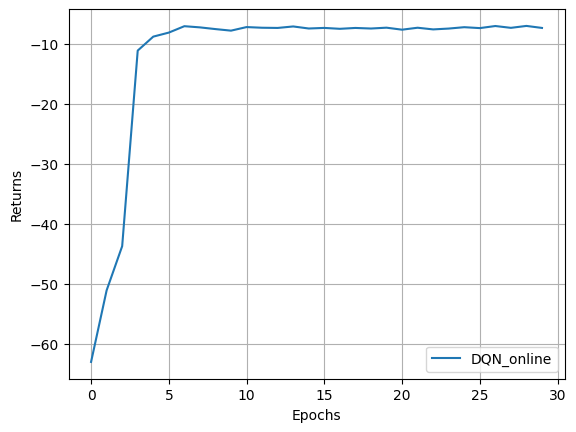

In [6]:
# вознаграждения
rollout_file = "./d3rlpy_logs/DQN_online_20240415235535/rollout_return.csv"
statistics = pd.read_csv(rollout_file, header=None)

plt.plot(statistics[2], label="DQN_online")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

In [7]:
optimal_data = dqn_buffer

### Сбор субоптимальных данных


In [8]:
def dataset_with_terminals(buffer, size):
    observations = []
    actions = []
    rewards = []
    terminals = []

    for episode in buffer.episodes[:size]:
        observations += episode.observations.tolist()
        actions += episode.actions.tolist()
        rewards += episode.rewards.tolist()

        terminal = [0 for _ in range(len(episode.rewards))]
        terminal[-1] = 1
        terminals += terminal
    return observations, actions, rewards, terminals


def make_mixed_dataset(dataset_1, dataset_2, proportions=[1, 1]):
    size_1 = int(len(dataset_1.episodes) * proportions[0])
    size_2 = int(len(dataset_2.episodes) * proportions[1])

    observations, actions, rewards, terminals = dataset_with_terminals(
        dataset_1, size_1
    )
    rnd_observations, rnd_actions, rnd_rewards, rnd_terminals = dataset_with_terminals(
        dataset_2, size_2
    )

    mxt_obs = np.asarray(observations + rnd_observations)
    mxt_actions = np.asarray(actions + rnd_actions)
    mxt_rewards = np.asarray(rewards + rnd_rewards)
    mxt_terminals = np.asarray(terminals + rnd_terminals).reshape(-1, 1)

    mixed_dataset = d3rlpy.dataset.MDPDataset(
        observations=mxt_obs,
        actions=mxt_actions,
        rewards=mxt_rewards,
        terminals=mxt_terminals,
    )
    return mixed_dataset


random_policy = d3rlpy.algos.DiscreteRandomPolicyConfig().create()

random_buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)

random_policy.collect(env, random_buffer, n_steps=100000)
suboptimal_data = make_mixed_dataset(optimal_data, random_buffer, (0.7, 0.3))

2024-04-16 00:09.57 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-04-16 00:09.57 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-16 00:09.57 [info     ] Action size has been automatically determined. action_size=5
2024-04-16 00:09.57 [debug    ] Building model...             
2024-04-16 00:09.57 [debug    ] Model has been built.         


  0%|          | 0/100000 [00:00<?, ?it/s]

2024-04-16 00:10.06 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-04-16 00:10.06 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-16 00:10.06 [info     ] Action size has been automatically determined. action_size=5


### Обучение Behavior Cloning (BC) на оптимальных данных


In [9]:
bc = d3rlpy.algos.DiscreteBCConfig(learning_rate=1e-4, gamma=0.9).create(
    device=DEVICE.type
)

# start training
stat_bc = bc.fit(
    dqn_buffer,
    n_steps=100000,
    n_steps_per_epoch=7000,
    evaluators={
        "environment": d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-16 00:10.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-16 00:10.11 [info     ] Directory is created at d3rlpy_logs/DiscreteBC_20240416001011
2024-04-16 00:10.11 [debug    ] Building models...            
2024-04-16 00:10.11 [debug    ] Models have been built.       
2024-04-16 00:10.11 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0

Epoch 1/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:10.57 [info     ] DiscreteBC_20240416001011: epoch=1 step=7000 epoch=1 metrics={'time_sample_batch': 0.003315650156566075, 'time_algorithm_update': 0.003170304707118443, 'loss': 2.736109905379159, 'time_step': 0.006550074917929513, 'environment': -3.3950335179817124} step=7000
2024-04-16 00:10.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_7000.d3


Epoch 2/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:11.43 [info     ] DiscreteBC_20240416001011: epoch=2 step=14000 epoch=2 metrics={'time_sample_batch': 0.003304494449070522, 'time_algorithm_update': 0.003159935099737985, 'loss': 2.735045928410121, 'time_step': 0.006530050413949149, 'environment': -3.3950335179817124} step=14000
2024-04-16 00:11.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_14000.d3


Epoch 3/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:12.30 [info     ] DiscreteBC_20240416001011: epoch=3 step=21000 epoch=3 metrics={'time_sample_batch': 0.0032938072340829034, 'time_algorithm_update': 0.0032446674619402206, 'loss': 2.7350709092276437, 'time_step': 0.006603394440242222, 'environment': -3.3950335179817124} step=21000
2024-04-16 00:12.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_21000.d3


Epoch 4/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:13.16 [info     ] DiscreteBC_20240416001011: epoch=4 step=28000 epoch=4 metrics={'time_sample_batch': 0.003268476928983416, 'time_algorithm_update': 0.0032257489136287144, 'loss': 2.73445869408335, 'time_step': 0.0065560355186462405, 'environment': -3.3950335179817124} step=28000
2024-04-16 00:13.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_28000.d3


Epoch 5/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:14.03 [info     ] DiscreteBC_20240416001011: epoch=5 step=35000 epoch=5 metrics={'time_sample_batch': 0.0032893386227743964, 'time_algorithm_update': 0.0032935993330819265, 'loss': 2.7348263221468243, 'time_step': 0.006645797729492187, 'environment': -3.3950335179817124} step=35000
2024-04-16 00:14.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_35000.d3


Epoch 6/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:14.50 [info     ] DiscreteBC_20240416001011: epoch=6 step=42000 epoch=6 metrics={'time_sample_batch': 0.003263927698135376, 'time_algorithm_update': 0.00324117990902492, 'loss': 2.7347547567571913, 'time_step': 0.00656474256515503, 'environment': -3.3950335179817124} step=42000
2024-04-16 00:14.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_42000.d3


Epoch 7/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:15.37 [info     ] DiscreteBC_20240416001011: epoch=7 step=49000 epoch=7 metrics={'time_sample_batch': 0.003273902416229248, 'time_algorithm_update': 0.0033917993818010604, 'loss': 2.73420973103387, 'time_step': 0.0067270611013684955, 'environment': -3.3950335179817124} step=49000
2024-04-16 00:15.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_49000.d3


Epoch 8/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:16.26 [info     ] DiscreteBC_20240416001011: epoch=8 step=56000 epoch=8 metrics={'time_sample_batch': 0.0032879577364240374, 'time_algorithm_update': 0.0036067282131740023, 'loss': 2.7341376307691845, 'time_step': 0.006957338060651507, 'environment': -3.3950335179817124} step=56000
2024-04-16 00:16.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_56000.d3


Epoch 9/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:17.14 [info     ] DiscreteBC_20240416001011: epoch=9 step=63000 epoch=9 metrics={'time_sample_batch': 0.003258180379867554, 'time_algorithm_update': 0.0034679034437452043, 'loss': 2.734949918815068, 'time_step': 0.006784955092838833, 'environment': -3.3950335179817124} step=63000
2024-04-16 00:17.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_63000.d3


Epoch 10/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:18.02 [info     ] DiscreteBC_20240416001011: epoch=10 step=70000 epoch=10 metrics={'time_sample_batch': 0.0033262805598122734, 'time_algorithm_update': 0.0033402541024344307, 'loss': 2.73421379334586, 'time_step': 0.006731775760650635, 'environment': -3.3950335179817124} step=70000
2024-04-16 00:18.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_70000.d3


Epoch 11/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:18.49 [info     ] DiscreteBC_20240416001011: epoch=11 step=77000 epoch=11 metrics={'time_sample_batch': 0.0032991126605442594, 'time_algorithm_update': 0.0034124211243220736, 'loss': 2.7344625730855125, 'time_step': 0.006775913953781128, 'environment': -3.3950335179817124} step=77000
2024-04-16 00:18.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_77000.d3


Epoch 12/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:19.38 [info     ] DiscreteBC_20240416001011: epoch=12 step=84000 epoch=12 metrics={'time_sample_batch': 0.003235684735434396, 'time_algorithm_update': 0.0035681204114641463, 'loss': 2.734387712580817, 'time_step': 0.00686264569418771, 'environment': -3.3950335179817124} step=84000
2024-04-16 00:19.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_84000.d3


Epoch 13/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:20.26 [info     ] DiscreteBC_20240416001011: epoch=13 step=91000 epoch=13 metrics={'time_sample_batch': 0.003228287833077567, 'time_algorithm_update': 0.0035709804466792514, 'loss': 2.7345368666648864, 'time_step': 0.006856682164328439, 'environment': -3.3950335179817124} step=91000
2024-04-16 00:20.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_91000.d3


Epoch 14/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:21.13 [info     ] DiscreteBC_20240416001011: epoch=14 step=98000 epoch=14 metrics={'time_sample_batch': 0.0033018761021750315, 'time_algorithm_update': 0.0033163454873221263, 'loss': 2.735284995623997, 'time_step': 0.006684516089303153, 'environment': -3.3950335179817124} step=98000
2024-04-16 00:21.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416001011/model_98000.d3


In [13]:
models_dict["bc_optimal"] = [val[1]["environment"] for val in stat_bc]

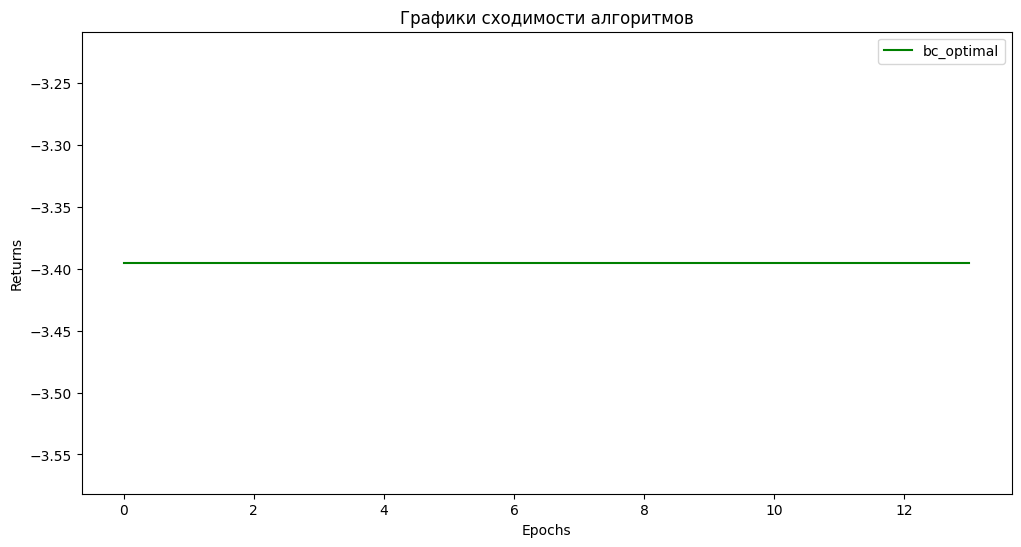

In [15]:
plot_lines(models_dict)

### Обучение Behavior Cloning (BC) на субоптимальных данных


In [16]:
bc = d3rlpy.algos.DiscreteBCConfig(learning_rate=1e-4, gamma=0.9).create(
    device=DEVICE.type
)

# start training
stat_bc_sub = bc.fit(
    suboptimal_data,
    n_steps=100000,
    n_steps_per_epoch=7000,
    evaluators={
        "environment": d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-16 00:21.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-16 00:21.49 [info     ] Directory is created at d3rlpy_logs/DiscreteBC_20240416002149
2024-04-16 00:21.49 [debug    ] Building models...            
2024-04-16 00:21.49 [debug    ] Models have been built.       
2024-04-16 00:21.49 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9

Epoch 1/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:22.28 [info     ] DiscreteBC_20240416002149: epoch=1 step=7000 epoch=1 metrics={'time_sample_batch': 0.002208282061985561, 'time_algorithm_update': 0.0032088049479893277, 'loss': 2.8082585488728116, 'time_step': 0.0054754703385489325, 'environment': 1.0} step=7000
2024-04-16 00:22.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_7000.d3


Epoch 2/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:23.08 [info     ] DiscreteBC_20240416002149: epoch=2 step=14000 epoch=2 metrics={'time_sample_batch': 0.0021711210182734897, 'time_algorithm_update': 0.0033677895409720284, 'loss': 2.8065932485035487, 'time_step': 0.005596192393984113, 'environment': 1.0} step=14000
2024-04-16 00:23.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_14000.d3


Epoch 3/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:23.46 [info     ] DiscreteBC_20240416002149: epoch=3 step=21000 epoch=3 metrics={'time_sample_batch': 0.002182076624461583, 'time_algorithm_update': 0.0032214809826442174, 'loss': 2.8059661385331833, 'time_step': 0.005461844614573887, 'environment': 1.0} step=21000
2024-04-16 00:23.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_21000.d3


Epoch 4/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:24.23 [info     ] DiscreteBC_20240416002149: epoch=4 step=28000 epoch=4 metrics={'time_sample_batch': 0.002201512132372175, 'time_algorithm_update': 0.0029115771225520543, 'loss': 2.8061141639096396, 'time_step': 0.005176387344087873, 'environment': 1.0} step=28000
2024-04-16 00:24.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_28000.d3


Epoch 5/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:25.01 [info     ] DiscreteBC_20240416002149: epoch=5 step=35000 epoch=5 metrics={'time_sample_batch': 0.0021973840509142196, 'time_algorithm_update': 0.0031674469198499406, 'loss': 2.8064088926996504, 'time_step': 0.005425291674477714, 'environment': 1.0} step=35000
2024-04-16 00:25.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_35000.d3


Epoch 6/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:25.39 [info     ] DiscreteBC_20240416002149: epoch=6 step=42000 epoch=6 metrics={'time_sample_batch': 0.002216601644243513, 'time_algorithm_update': 0.00306095358303615, 'loss': 2.8061195039749145, 'time_step': 0.005343051399503435, 'environment': 1.0} step=42000
2024-04-16 00:25.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_42000.d3


Epoch 7/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:26.17 [info     ] DiscreteBC_20240416002149: epoch=7 step=49000 epoch=7 metrics={'time_sample_batch': 0.002182927199772426, 'time_algorithm_update': 0.0032407832145690918, 'loss': 2.8066531405108317, 'time_step': 0.005481506177357265, 'environment': 1.0} step=49000
2024-04-16 00:26.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_49000.d3


Epoch 8/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:26.56 [info     ] DiscreteBC_20240416002149: epoch=8 step=56000 epoch=8 metrics={'time_sample_batch': 0.002217063903808594, 'time_algorithm_update': 0.003177821057183402, 'loss': 2.806809221642358, 'time_step': 0.005457287992749895, 'environment': 1.0} step=56000
2024-04-16 00:26.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_56000.d3


Epoch 9/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:27.35 [info     ] DiscreteBC_20240416002149: epoch=9 step=63000 epoch=9 metrics={'time_sample_batch': 0.002241831370762416, 'time_algorithm_update': 0.003207820551736014, 'loss': 2.8061589845929826, 'time_step': 0.005516702549798148, 'environment': 1.0} step=63000
2024-04-16 00:27.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_63000.d3


Epoch 10/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:28.13 [info     ] DiscreteBC_20240416002149: epoch=10 step=70000 epoch=10 metrics={'time_sample_batch': 0.0022169156074523925, 'time_algorithm_update': 0.0031598261424473353, 'loss': 2.806450698409762, 'time_step': 0.005440097638538905, 'environment': 1.0} step=70000
2024-04-16 00:28.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_70000.d3


Epoch 11/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:28.52 [info     ] DiscreteBC_20240416002149: epoch=11 step=77000 epoch=11 metrics={'time_sample_batch': 0.0022179676805223736, 'time_algorithm_update': 0.0031249200616564068, 'loss': 2.806020718063627, 'time_step': 0.0054069727829524445, 'environment': 1.0} step=77000
2024-04-16 00:28.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_77000.d3


Epoch 12/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:29.29 [info     ] DiscreteBC_20240416002149: epoch=12 step=84000 epoch=12 metrics={'time_sample_batch': 0.0022070200783865794, 'time_algorithm_update': 0.003080482278551374, 'loss': 2.8060402409349168, 'time_step': 0.0053513275555201936, 'environment': 1.0} step=84000
2024-04-16 00:29.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_84000.d3


Epoch 13/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:30.07 [info     ] DiscreteBC_20240416002149: epoch=13 step=91000 epoch=13 metrics={'time_sample_batch': 0.0022288362639290944, 'time_algorithm_update': 0.0030387542588370185, 'loss': 2.8057397750105175, 'time_step': 0.005330275126865932, 'environment': 1.0} step=91000
2024-04-16 00:30.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_91000.d3


Epoch 14/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-16 00:30.44 [info     ] DiscreteBC_20240416002149: epoch=14 step=98000 epoch=14 metrics={'time_sample_batch': 0.0022236454827444896, 'time_algorithm_update': 0.002943499735423497, 'loss': 2.806893510273525, 'time_step': 0.005230549267360142, 'environment': 1.0} step=98000
2024-04-16 00:30.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240416002149/model_98000.d3


In [17]:
models_dict["bc_suboptimal"] = [val[1]["environment"] for val in stat_bc_sub]

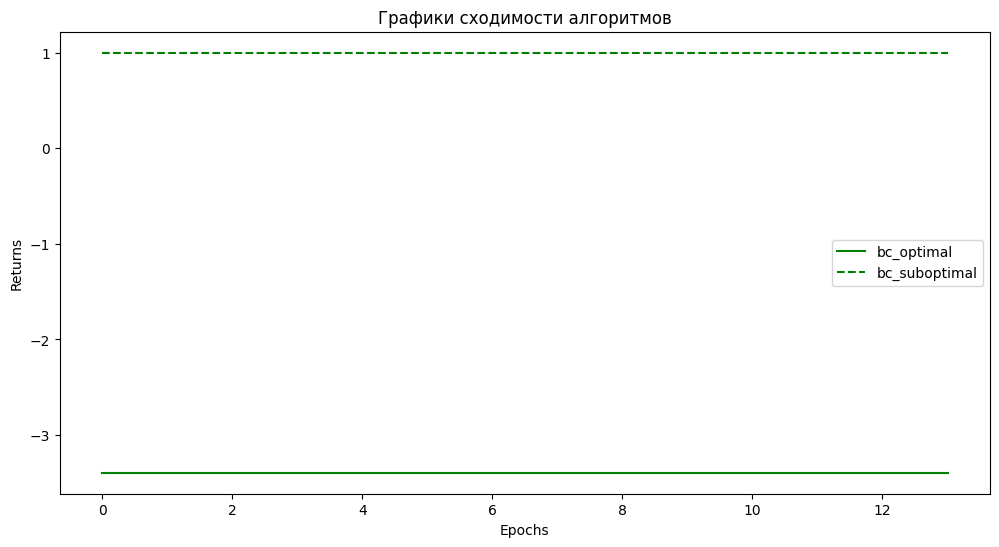

In [18]:
plot_lines(models_dict)

### Обучаем CQL на оптимальных данных


In [19]:
cql = d3rlpy.algos.DiscreteCQLConfig(learning_rate=1e-4, gamma=0.9).create(
    device=DEVICE.type
)

stat_cql_opt = cql.fit(
    optimal_data,
    n_steps=50000,
    n_steps_per_epoch=5000,
    evaluators={
        "environment": d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-16 00:30.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-16 00:30.57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240416003057
2024-04-16 00:30.57 [debug    ] Building models...            
2024-04-16 00:30.57 [debug    ] Models have been built.       
2024-04-16 00:30.57 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:31.24 [info     ] DiscreteCQL_20240416003057: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.0012106140613555908, 'time_algorithm_update': 0.003991010808944702, 'loss': 1.3201342006206513, 'td_loss': 0.11329839644283056, 'conservative_loss': 1.20683580391407, 'time_step': 0.005296322917938232, 'environment': 1.0} step=5000
2024-04-16 00:31.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_5000.d3


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:31.51 [info     ] DiscreteCQL_20240416003057: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.0012597568988800048, 'time_algorithm_update': 0.004095210075378418, 'loss': 1.3093529401421546, 'td_loss': 0.1137989372856915, 'conservative_loss': 1.1955540031075478, 'time_step': 0.00545595645904541, 'environment': 1.0} step=10000
2024-04-16 00:31.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_10000.d3


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:32.19 [info     ] DiscreteCQL_20240416003057: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.001224114990234375, 'time_algorithm_update': 0.004081709384918213, 'loss': 1.3015695039987565, 'td_loss': 0.11006232035532594, 'conservative_loss': 1.191507183277607, 'time_step': 0.005404497432708741, 'environment': 1.0} step=15000
2024-04-16 00:32.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_15000.d3


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:32.45 [info     ] DiscreteCQL_20240416003057: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.0011910307884216308, 'time_algorithm_update': 0.003928668975830078, 'loss': 1.2929711374640465, 'td_loss': 0.10563791852220893, 'conservative_loss': 1.1873332193493844, 'time_step': 0.005206656789779663, 'environment': 1.0} step=20000
2024-04-16 00:32.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_20000.d3


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:33.12 [info     ] DiscreteCQL_20240416003057: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.0012103590488433838, 'time_algorithm_update': 0.004043142938613892, 'loss': 1.2870562094211577, 'td_loss': 0.10380170982778072, 'conservative_loss': 1.183254498243332, 'time_step': 0.005346035051345825, 'environment': 1.0} step=25000
2024-04-16 00:33.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_25000.d3


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:33.39 [info     ] DiscreteCQL_20240416003057: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0012387424945831298, 'time_algorithm_update': 0.0040273856163024905, 'loss': 1.28314296374321, 'td_loss': 0.09923230020329356, 'conservative_loss': 1.1839106637120247, 'time_step': 0.005365234899520874, 'environment': 1.0} step=30000
2024-04-16 00:33.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_30000.d3


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:34.05 [info     ] DiscreteCQL_20240416003057: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.001170942497253418, 'time_algorithm_update': 0.003961505794525147, 'loss': 1.2834435008049012, 'td_loss': 0.0995351274214685, 'conservative_loss': 1.1839083724617958, 'time_step': 0.00521791501045227, 'environment': 1.0} step=35000
2024-04-16 00:34.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_35000.d3


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:34.32 [info     ] DiscreteCQL_20240416003057: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.0012014665126800538, 'time_algorithm_update': 0.003949530506134033, 'loss': 1.28035084182024, 'td_loss': 0.09885413664951921, 'conservative_loss': 1.1814967047929763, 'time_step': 0.0052439993381500245, 'environment': 1.0} step=40000
2024-04-16 00:34.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_40000.d3


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:34.59 [info     ] DiscreteCQL_20240416003057: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.001200074052810669, 'time_algorithm_update': 0.004025141477584839, 'loss': 1.2768141305565834, 'td_loss': 0.09765540120527148, 'conservative_loss': 1.1791587295413017, 'time_step': 0.00532109727859497, 'environment': 1.0} step=45000
2024-04-16 00:34.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_45000.d3


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:35.25 [info     ] DiscreteCQL_20240416003057: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.0012038906097412109, 'time_algorithm_update': 0.0039956416606903074, 'loss': 1.2756507439613343, 'td_loss': 0.09753661047369241, 'conservative_loss': 1.1781141333937646, 'time_step': 0.005294601964950562, 'environment': 1.0} step=50000
2024-04-16 00:35.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416003057/model_50000.d3


In [21]:
models_dict["cql_optimal"] = [val[1]["environment"] for val in stat_cql_opt]

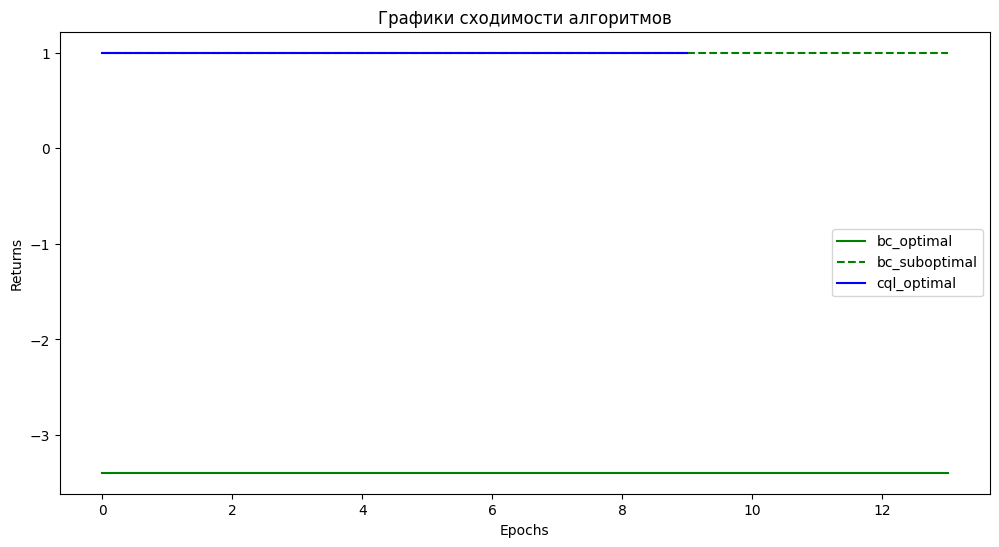

In [22]:
plot_lines(models_dict)

### Обучаем CQL на субоптимальных данных

In [24]:
cql = d3rlpy.algos.DiscreteCQLConfig(learning_rate=1e-4, gamma=0.9).create(
    device=DEVICE.type
)

stat_cql_sub = cql.fit(
    suboptimal_data,
    n_steps=50000,
    n_steps_per_epoch=5000,
    evaluators={
        "environment": d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-16 00:45.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-16 00:45.17 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240416004517
2024-04-16 00:45.17 [debug    ] Building models...            
2024-04-16 00:45.17 [debug    ] Models have been built.       
2024-04-16 00:45.17 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:45.43 [info     ] DiscreteCQL_20240416004517: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.0008492292881011963, 'time_algorithm_update': 0.004039123725891113, 'loss': 1.448102487397194, 'td_loss': 0.065375779119879, 'conservative_loss': 1.382726709008217, 'time_step': 0.004986572551727295, 'environment': 1.0} step=5000
2024-04-16 00:45.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_5000.d3


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:46.07 [info     ] DiscreteCQL_20240416004517: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.0008360793590545655, 'time_algorithm_update': 0.00385159158706665, 'loss': 1.439570624899864, 'td_loss': 0.06673367058262229, 'conservative_loss': 1.3728369546890258, 'time_step': 0.004785017442703247, 'environment': 1.0} step=10000
2024-04-16 00:46.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_10000.d3


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:46.31 [info     ] DiscreteCQL_20240416004517: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.000821980619430542, 'time_algorithm_update': 0.003871419095993042, 'loss': 1.4310232632875441, 'td_loss': 0.06266203705444932, 'conservative_loss': 1.3683612259149551, 'time_step': 0.004788064289093018, 'environment': 1.0} step=15000
2024-04-16 00:46.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_15000.d3


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:46.55 [info     ] DiscreteCQL_20240416004517: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.0008374515056610107, 'time_algorithm_update': 0.003910262537002563, 'loss': 1.4282881350278855, 'td_loss': 0.060565755948796866, 'conservative_loss': 1.3677223783969878, 'time_step': 0.004846356678009033, 'environment': 1.0} step=20000
2024-04-16 00:46.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_20000.d3


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:47.20 [info     ] DiscreteCQL_20240416004517: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.0008383647918701172, 'time_algorithm_update': 0.003921224689483643, 'loss': 1.4245822901010514, 'td_loss': 0.05897647031806409, 'conservative_loss': 1.3656058190584184, 'time_step': 0.004858239555358887, 'environment': 1.0} step=25000
2024-04-16 00:47.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_25000.d3


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:47.44 [info     ] DiscreteCQL_20240416004517: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0008327021121978759, 'time_algorithm_update': 0.00380383358001709, 'loss': 1.4214733563661575, 'td_loss': 0.05672975396811962, 'conservative_loss': 1.3647436025619506, 'time_step': 0.004727188587188721, 'environment': 1.0} step=30000
2024-04-16 00:47.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_30000.d3


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:48.08 [info     ] DiscreteCQL_20240416004517: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0008214884281158447, 'time_algorithm_update': 0.003829636287689209, 'loss': 1.416229905128479, 'td_loss': 0.05824514621347189, 'conservative_loss': 1.3579847581386566, 'time_step': 0.004740906429290772, 'environment': 1.0} step=35000
2024-04-16 00:48.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_35000.d3


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:48.31 [info     ] DiscreteCQL_20240416004517: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.000817463493347168, 'time_algorithm_update': 0.0037229366302490236, 'loss': 1.4184500945329666, 'td_loss': 0.05700519878007471, 'conservative_loss': 1.3614448965549468, 'time_step': 0.004627621746063232, 'environment': 1.0} step=40000
2024-04-16 00:48.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_40000.d3


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:48.55 [info     ] DiscreteCQL_20240416004517: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.0008135044574737549, 'time_algorithm_update': 0.0037915203094482423, 'loss': 1.4190585513353349, 'td_loss': 0.05667256217226386, 'conservative_loss': 1.3623859892129897, 'time_step': 0.004692638254165649, 'environment': 1.0} step=45000
2024-04-16 00:48.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_45000.d3


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-16 00:49.18 [info     ] DiscreteCQL_20240416004517: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.0008223322868347168, 'time_algorithm_update': 0.003782904815673828, 'loss': 1.4168121404409408, 'td_loss': 0.05757990518547595, 'conservative_loss': 1.359232235479355, 'time_step': 0.004698493242263794, 'environment': 1.0} step=50000
2024-04-16 00:49.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240416004517/model_50000.d3


In [27]:
models_dict["cql_suboptimal"] = [val[1]["environment"] for val in stat_cql_sub]

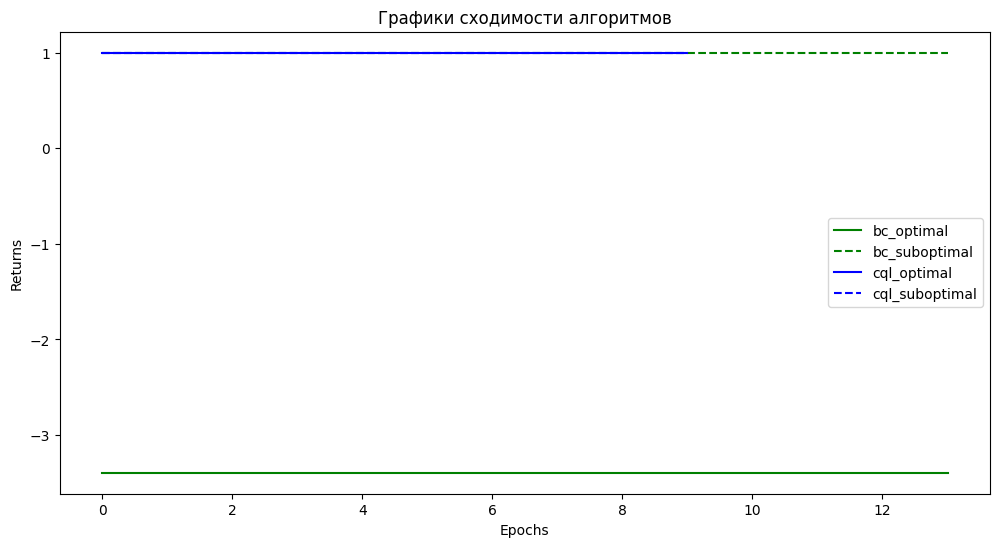

In [28]:
plot_lines(models_dict)

### Обучени DT на оптимальных данных

In [29]:
dt = d3rlpy.algos.DiscreteDecisionTransformerConfig().create(device=DEVICE.type)

dt.fit(
    optimal_data,
    n_steps=10000,
    n_steps_per_epoch=1000,
    eval_env=env,
    eval_target_return=0,
    eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(),
)

2024-04-16 00:53.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-16 00:53.46 [info     ] Directory is created at d3rlpy_logs/DiscreteDecisionTransformer_20240416005346
2024-04-16 00:53.46 [debug    ] Building models...            
2024-04-16 00:53.46 [debug    ] Models have been built.       
2024-04-16 00:53.46 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_decision_transformer', 'params': {'batch_size': 128, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'context_size': 20, 'max_timestep': 1000, 'learnin

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:54.28 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.005770832300186157, 'time_algorithm_update': 0.034645239114761354, 'loss': 0.5992135599851608, 'learning_rate': 0.0005970024240145154, 'time_step': 0.04047992920875549, 'environment': 1.0} step=1000
2024-04-16 00:54.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:55.12 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.005746836423873901, 'time_algorithm_update': 0.034622136354446414, 'loss': 0.5810661677420139, 'learning_rate': 0.0005925018095983124, 'time_step': 0.040426897048950194, 'environment': 0.7} step=2000
2024-04-16 00:55.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:55.56 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.00573865008354187, 'time_algorithm_update': 0.03471590566635132, 'loss': 0.574970408976078, 'learning_rate': 0.0005797246787925986, 'time_step': 0.04051333737373352, 'environment': 0.8} step=3000
2024-04-16 00:55.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:56.42 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.0057651219367980955, 'time_algorithm_update': 0.03451446557044983, 'loss': 0.5533353941440582, 'learning_rate': 0.0005608821303278751, 'time_step': 0.04033974432945252, 'environment': 0.1} step=4000
2024-04-16 00:56.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:57.26 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.0057954504489898685, 'time_algorithm_update': 0.034758548021316525, 'loss': 0.5244408344626427, 'learning_rate': 0.0005363920455366605, 'time_step': 0.04061419582366944, 'environment': 0.7} step=5000
2024-04-16 00:57.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:58.10 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.005783872127532959, 'time_algorithm_update': 0.03481930470466614, 'loss': 0.4998450412154198, 'learning_rate': 0.0005067327907614895, 'time_step': 0.040663008213043215, 'environment': 0.9} step=6000
2024-04-16 00:58.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:58.55 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.00577626895904541, 'time_algorithm_update': 0.03494001698493958, 'loss': 0.4815683033466339, 'learning_rate': 0.00047267641142667506, 'time_step': 0.040779302597045895, 'environment': 0.6} step=7000
2024-04-16 00:58.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 00:59.38 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.005687548160552979, 'time_algorithm_update': 0.032434083223342895, 'loss': 0.469759935349226, 'learning_rate': 0.00043481572384301625, 'time_step': 0.03817977881431579, 'environment': 0.2} step=8000
2024-04-16 00:59.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:00.22 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.0056960263252258305, 'time_algorithm_update': 0.032495149612426756, 'loss': 0.4576703714728355, 'learning_rate': 0.00039395771191351583, 'time_step': 0.03824806523323059, 'environment': 0.0} step=9000
2024-04-16 01:00.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:01.08 [info     ] DiscreteDecisionTransformer_20240416005346: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.0057112557888031, 'time_algorithm_update': 0.03445278191566467, 'loss': 0.44807796266674993, 'learning_rate': 0.000351209898011289, 'time_step': 0.040223257541656496, 'environment': 0.0} step=10000
2024-04-16 01:01.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/model_10000.d3


In [35]:
environment_file = (
    "./d3rlpy_logs/DiscreteDecisionTransformer_20240416005346/environment.csv"
)
statistics = pd.read_csv(environment_file, header=None)

,0,1,2
0,1,1000,1.0
1,2,2000,0.7
2,3,3000,0.8
3,4,4000,0.1
4,5,5000,0.7
5,6,6000,0.9
6,7,7000,0.6
7,8,8000,0.2
8,9,9000,0.0
9,10,10000,0.0


In [36]:
models_dict["dt_optimal"] = statistics[2]

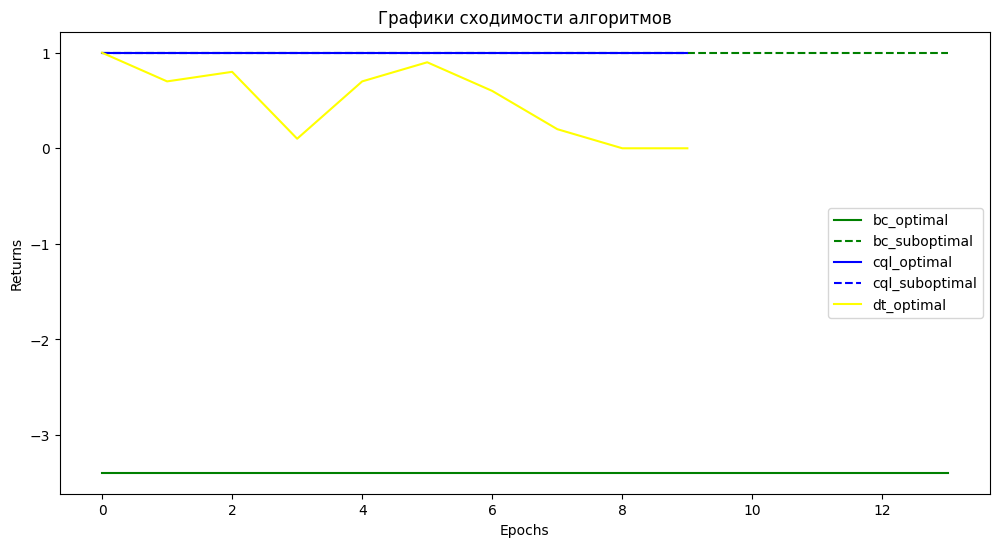

In [37]:
plot_lines(models_dict)

### Обучени DT на субоптимальных данных

In [38]:
dt = d3rlpy.algos.DiscreteDecisionTransformerConfig().create(device=DEVICE.type)

dt.fit(
    suboptimal_data,
    n_steps=10000,
    n_steps_per_epoch=1000,
    eval_env=env,
    eval_target_return=0,
    eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(),
)

2024-04-16 01:08.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-16 01:08.32 [info     ] Directory is created at d3rlpy_logs/DiscreteDecisionTransformer_20240416010832
2024-04-16 01:08.32 [debug    ] Building models...            
2024-04-16 01:08.32 [debug    ] Models have been built.       
2024-04-16 01:08.32 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_decision_transformer', 'params': {'batch_size': 128, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'context_size': 20, 'max_timestep': 1000, 'lear

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:09.15 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0046844959259033205, 'time_algorithm_update': 0.03612264013290405, 'loss': 0.8731476203203201, 'learning_rate': 0.0005968838631708429, 'time_step': 0.04087538433074951, 'environment': 0.9} step=1000
2024-04-16 01:09.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:09.57 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.004670670747756958, 'time_algorithm_update': 0.03525973033905029, 'loss': 0.8570076779723167, 'learning_rate': 0.0005890706521927038, 'time_step': 0.03999730563163757, 'environment': 0.9} step=2000
2024-04-16 01:09.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:10.43 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.004768375158309936, 'time_algorithm_update': 0.037684232473373415, 'loss': 0.8538644478321076, 'learning_rate': 0.0005706066018617169, 'time_step': 0.042524431228637694, 'environment': 0.7} step=3000
2024-04-16 01:10.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:11.26 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.0047168233394622805, 'time_algorithm_update': 0.03594398307800293, 'loss': 0.8513604253530502, 'learning_rate': 0.0005435739898773586, 'time_step': 0.0407280797958374, 'environment': 0.9} step=4000
2024-04-16 01:11.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:12.06 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.004705994606018066, 'time_algorithm_update': 0.033627305269241334, 'loss': 0.8439628716111183, 'learning_rate': 0.0005089186874783801, 'time_step': 0.03840173697471619, 'environment': 1.0} step=5000
2024-04-16 01:12.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:12.45 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.004593048572540283, 'time_algorithm_update': 0.03197320795059204, 'loss': 0.8441834467053413, 'learning_rate': 0.00046768749543106206, 'time_step': 0.03662815499305725, 'environment': 0.8} step=6000
2024-04-16 01:12.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:13.28 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.004731042861938477, 'time_algorithm_update': 0.036225069522857666, 'loss': 0.8377373650670051, 'learning_rate': 0.0004211638724700871, 'time_step': 0.041028692245483396, 'environment': 0.9} step=7000
2024-04-16 01:13.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:14.11 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.004643009185791015, 'time_algorithm_update': 0.036400429010391235, 'loss': 0.8253049805760384, 'learning_rate': 0.0003707842360468801, 'time_step': 0.04110907006263733, 'environment': 1.0} step=8000
2024-04-16 01:14.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:14.54 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.004636655807495118, 'time_algorithm_update': 0.036232967615127565, 'loss': 0.8140253568291664, 'learning_rate': 0.00031826354012586726, 'time_step': 0.04093573117256165, 'environment': 1.0} step=9000
2024-04-16 01:14.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-16 01:15.37 [info     ] DiscreteDecisionTransformer_20240416010832: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.004718809127807617, 'time_algorithm_update': 0.036819924831390384, 'loss': 0.7965272482633591, 'learning_rate': 0.0002649415696268973, 'time_step': 0.04160716795921326, 'environment': 1.0} step=10000
2024-04-16 01:15.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/model_10000.d3


In [40]:
environment_file = (
    "./d3rlpy_logs/DiscreteDecisionTransformer_20240416010832/environment.csv"
)
statistics = pd.read_csv(environment_file, header=None)

models_dict["dt_suboptimal"] = statistics[2]

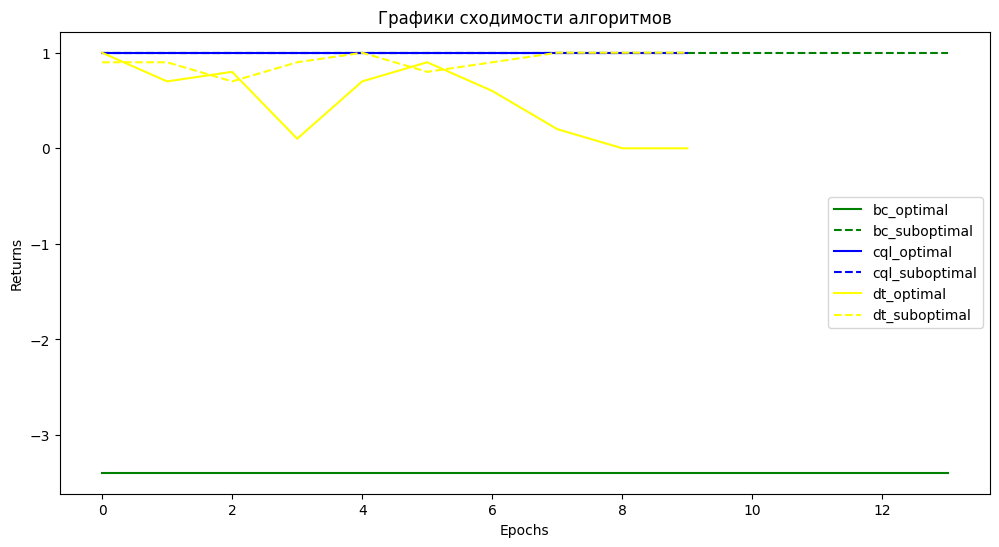

In [41]:
# финал

plot_lines(models_dict)

выводы: 
- BC дал лучше результат на субоптимальных стратегиях
- обучения на оптимальных или на субоптимальных стратегиях дает одинаковый результат у CQL (на графике линии слились)
- dt лучше сходится на субоптимальных стратегиях после 6 эпохи в сравнении с обучением на оптимальных стратегиях 